# Show how we can inject a pulse into a GREENBURST filterbank.

In [1]:
import tempfile
from urllib import request

import matplotlib.pyplot as plt
import numpy as np
from jess.dispersion import dedisperse
from jess.fitters import median_fitter
from scipy.stats import median_abs_deviation
from will import create, inject
from your import Your

In [2]:
def show_dynamic(
    dynamic_spectra: np.ndarray, title: str = None, save: bool = False
) -> None:
    """
    Show a dynamic spectra by first flattening it
    in frequency. Do this by getting the medians of
    each channel and then run a median filter along the
    bandpass.

    Then set the limits of the imshow so we get good detail
    for the majority of the data.

    Args:
        dynmaic_spectra - the dynamic spectra to plot

        title - Title of plot

        save - Save the plot as `title` + `.png`
    """
    spectra_mads = median_fitter(np.median(dynamic_spectra, axis=0))
    flat = dynamic_spectra - spectra_mads
    std = median_abs_deviation(flat, axis=None)
    med = np.median(flat)
    plt.figure(figsize=(20, 10))
    plt.imshow(flat.T, vmin=med - 3 * std, vmax=med + 6 * std, aspect="auto")
    plt.xlabel("Time Sample #", size=20)
    plt.ylabel("Channel #", size=20)
    plt.colorbar()
    plt.tight_layout()
    if title is not None:
        plt.title(title, size=28)
    if save:
        plt.savefig(title + ".png", dpi=200)

## Get a pulse search mode file

In [3]:
# Get a 33MB filbterbank from zenodo, put it in
# a temp directory
temp_dir = tempfile.TemporaryDirectory()
empty_fil = temp_dir.name + "/empty_example.fil"
request.urlretrieve(
    "https://zenodo.org/record/5860557/files/empty_example.fil", empty_fil
)

('/tmp/tmpy53f97lj/empty_example.fil',
 <http.client.HTTPMessage at 0x7f9de46c5130>)

In [4]:
yr_obj = Your(empty_fil)
dynamic_spectra = yr_obj.get_data(0, 8192)

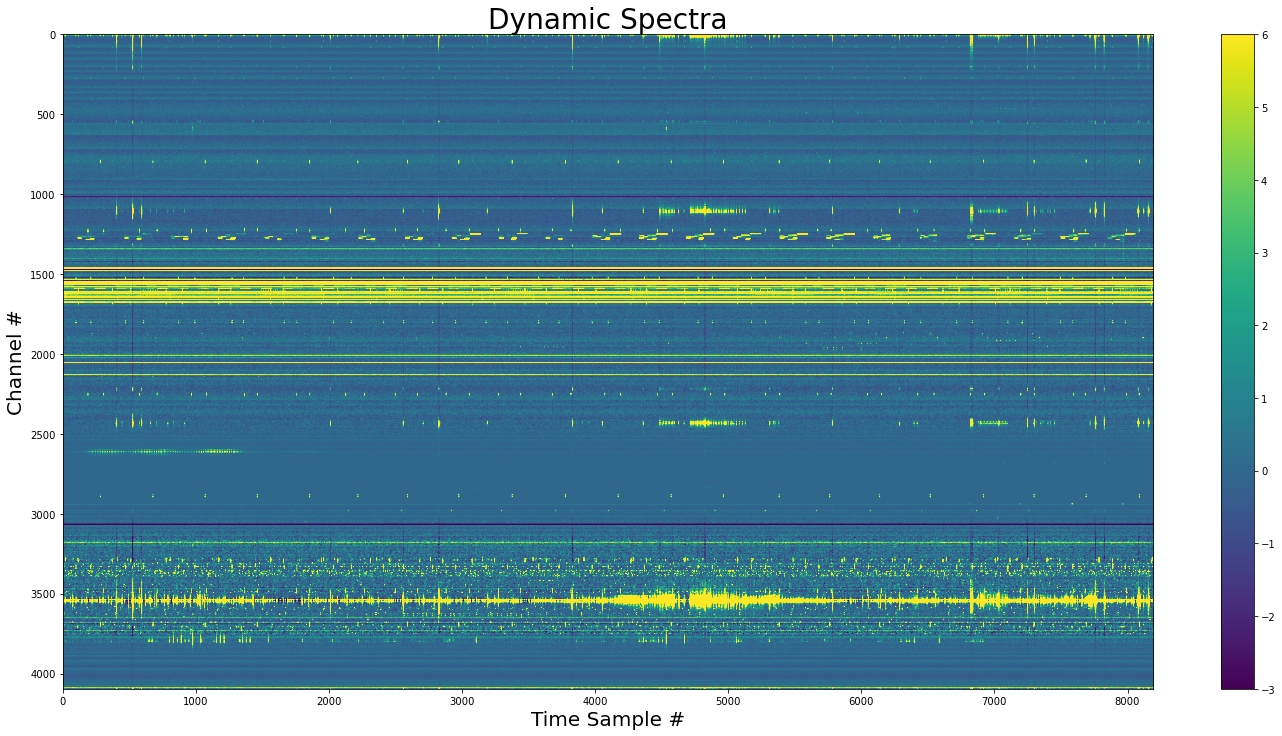

In [5]:
# Show the base dynamic spectra
show_dynamic(dynamic_spectra, title="Dynamic Spectra")

## Find a bandpass to scale the frequency structure

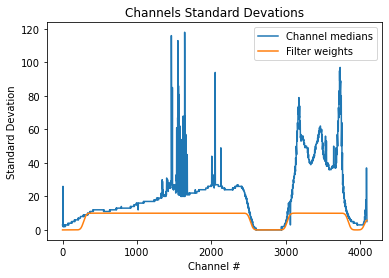

In [6]:
plt.title("Channels Standard Devations")
plt.xlabel("Channel #")
plt.ylabel("Standard Devation")
medians = np.median(dynamic_spectra, axis=0)
plt.plot(medians, label="Channel medians")
filter_weights = create.filter_weights(dynamic_spectra)
# mutlipy by 10 to make it easier to see
plt.plot(10 * filter_weights, label="Filter weights")
plt.legend()

## Create the pulse

In [7]:
dm = 200
# create the pulse object
pulse_obj = create.SimpleGaussPulse(
    sigma_time=0.001,
    sigma_freq=350,
    center_freq=yr_obj.your_header.center_freq,
    dm=dm,
    tau=20,
    phi=np.pi / 3,
    spectral_index_alpha=0,
    chan_freqs=yr_obj.chan_freqs,
    tsamp=yr_obj.your_header.tsamp,
    nscint=0,
    bandpass=filter_weights,
)
# pulse with 3e5 samples
pulse = pulse_obj.sample_pulse(nsamp=int(3e5))

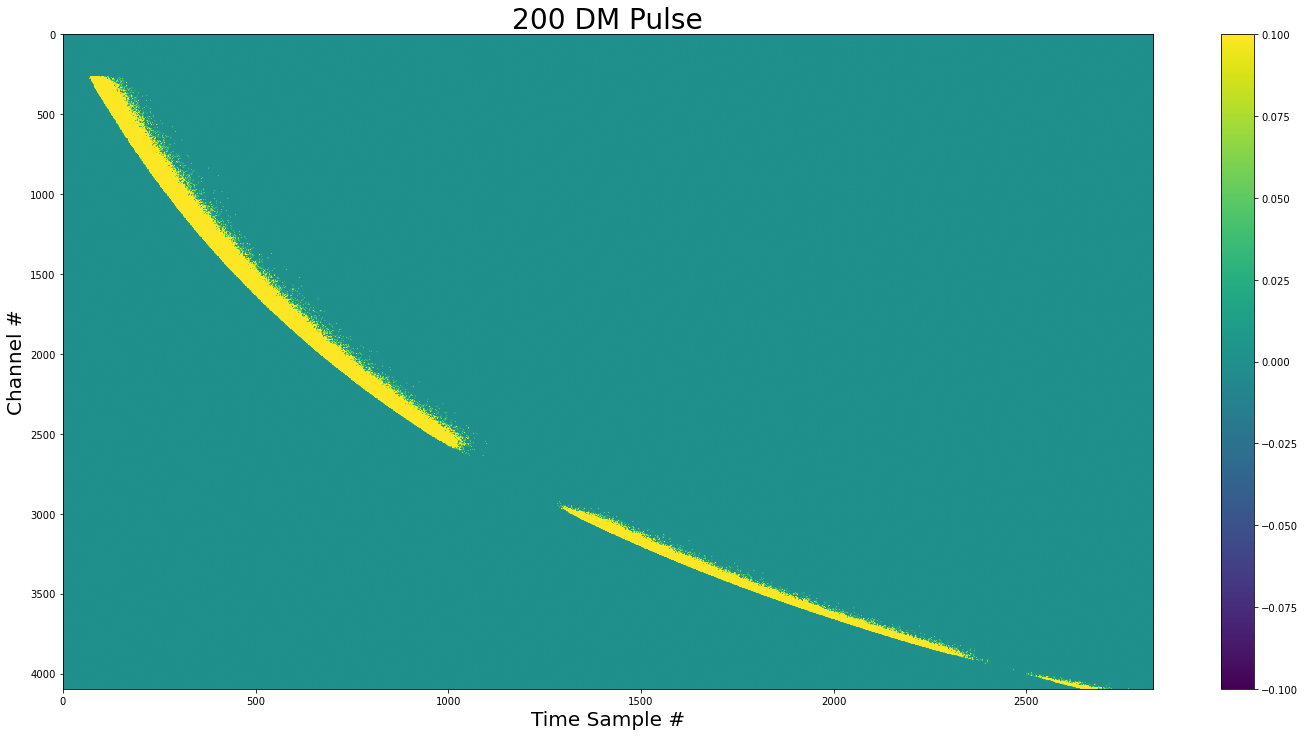

In [8]:
show_dynamic(pulse, title=f"{dm} DM Pulse")

We can see that there is not pulse in areas with zero variance (Like the cavity filter).

## Inject the pulse

In [9]:
dynamic_spectra_w_pulse = inject.inject_constant_into_file(
    yr_input=yr_obj,
    pulse=pulse,
    start=yr_obj.your_header.nspectra // 2 - 1024,
    gulp=yr_obj.your_header.nspectra,
)

Output()

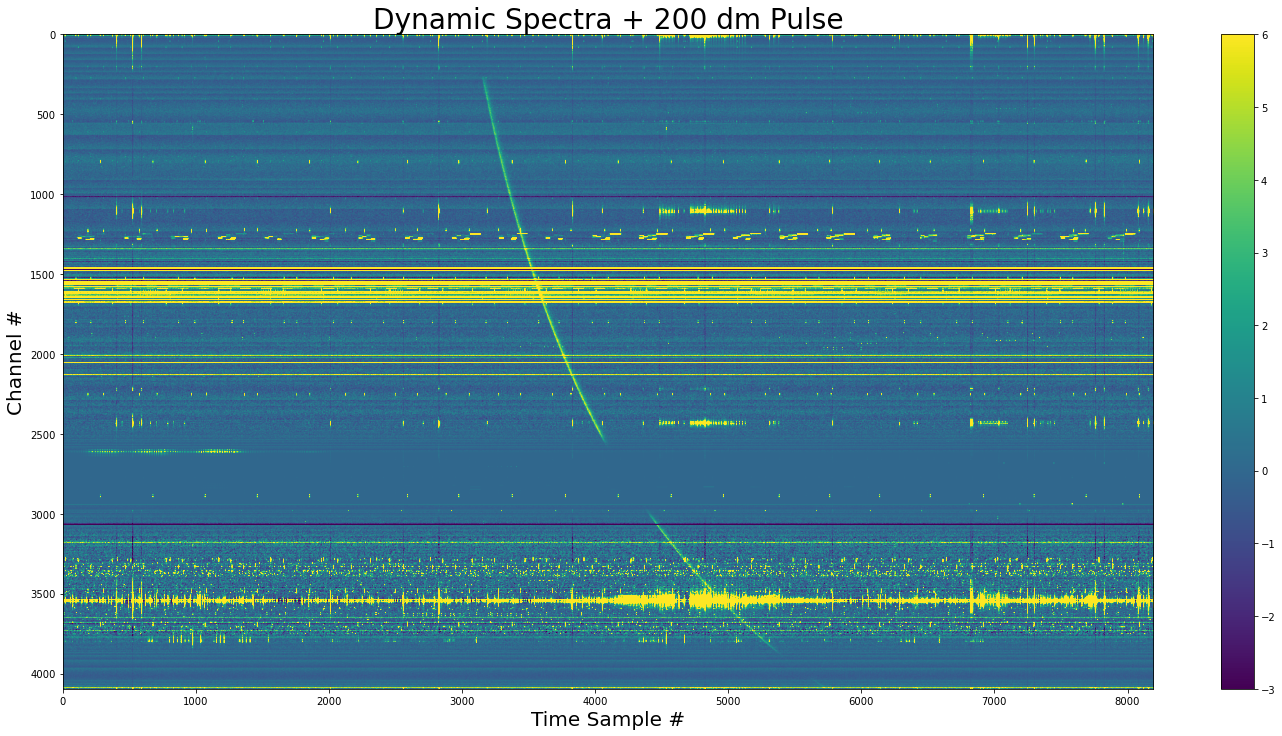

In [10]:
show_dynamic(dynamic_spectra_w_pulse, title=f"Dynamic Spectra + {dm} dm Pulse")

The pulse added to the dynamic spectra. We see that the pulse doesn't exist where the channel variances are zero.

## Pulse with complex frequency-time structure

This method samples all of the channels independently. It can accommodate changes in frequency and time, allowing for drifts, etc.
The disadvantage that this is computationally more expansive making it ~10 times slower

In [11]:
dm_1 = 155
pulse_obj_complex = create.GaussPulse(
    relative_intesities=(1, 0.8, 0.8, 1),
    sigma_times=(0.005, 0.001, 0.001, 0.003),
    sigma_freqs=(150, 120, 120, 90),
    center_freqs=(1500, 1400, 1350, 1250),
    dm=dm_1,
    tau=25,
    offsets=(0, 60, 90, 140),  # all from beining of pulse
    chan_freqs=yr_obj.chan_freqs,
    tsamp=0.000256,
    spectral_index_alpha=0,
    nscint=2,
    phi=0,
    bandpass=filter_weights,
)
# pulse with 3e5 samples
pulse_complex = pulse_obj_complex.sample_pulse(nsamp=int(3e5))

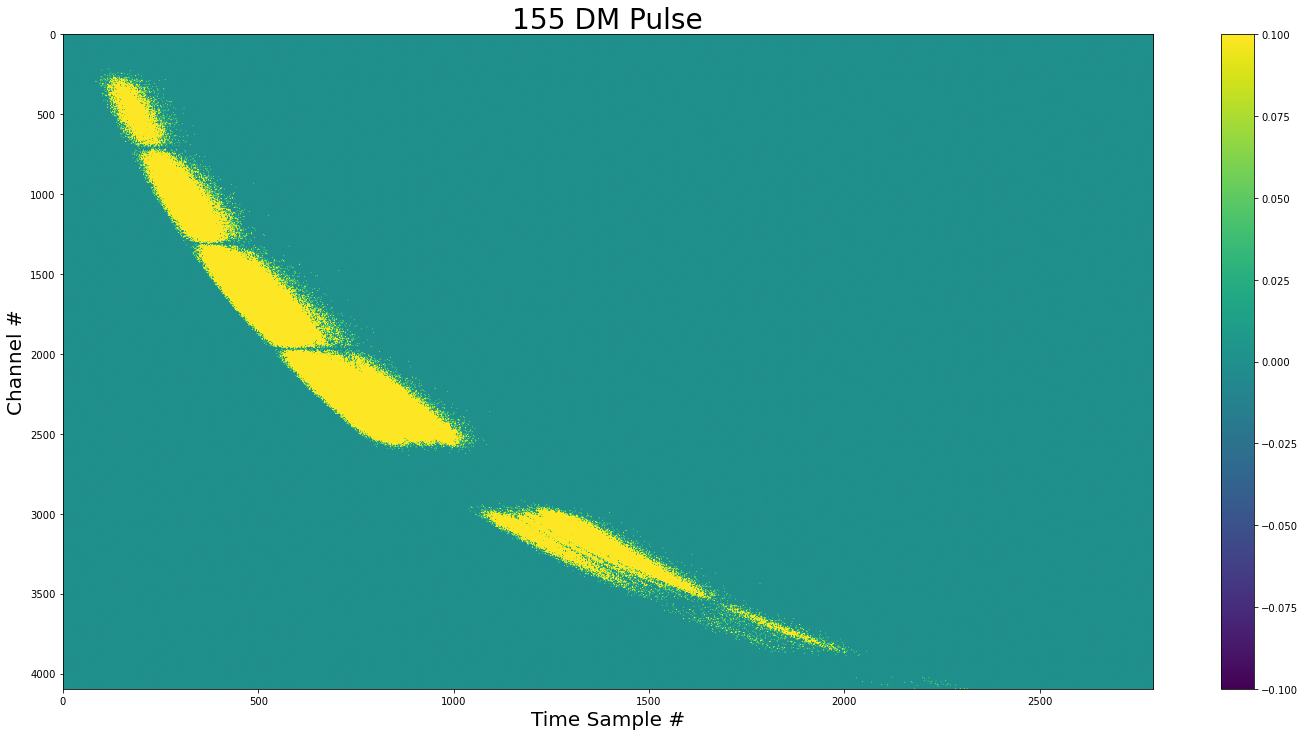

In [12]:
show_dynamic(pulse_complex, title=f"{dm_1} DM Pulse")

In [13]:
dynamic_spectra_w_complex_pulse = inject.inject_constant_into_file(
    yr_input=yr_obj,
    pulse=pulse_complex,
    start=yr_obj.your_header.nspectra // 2 - pulse_obj_complex.pulse_center,
    gulp=yr_obj.your_header.nspectra,
)

Output()

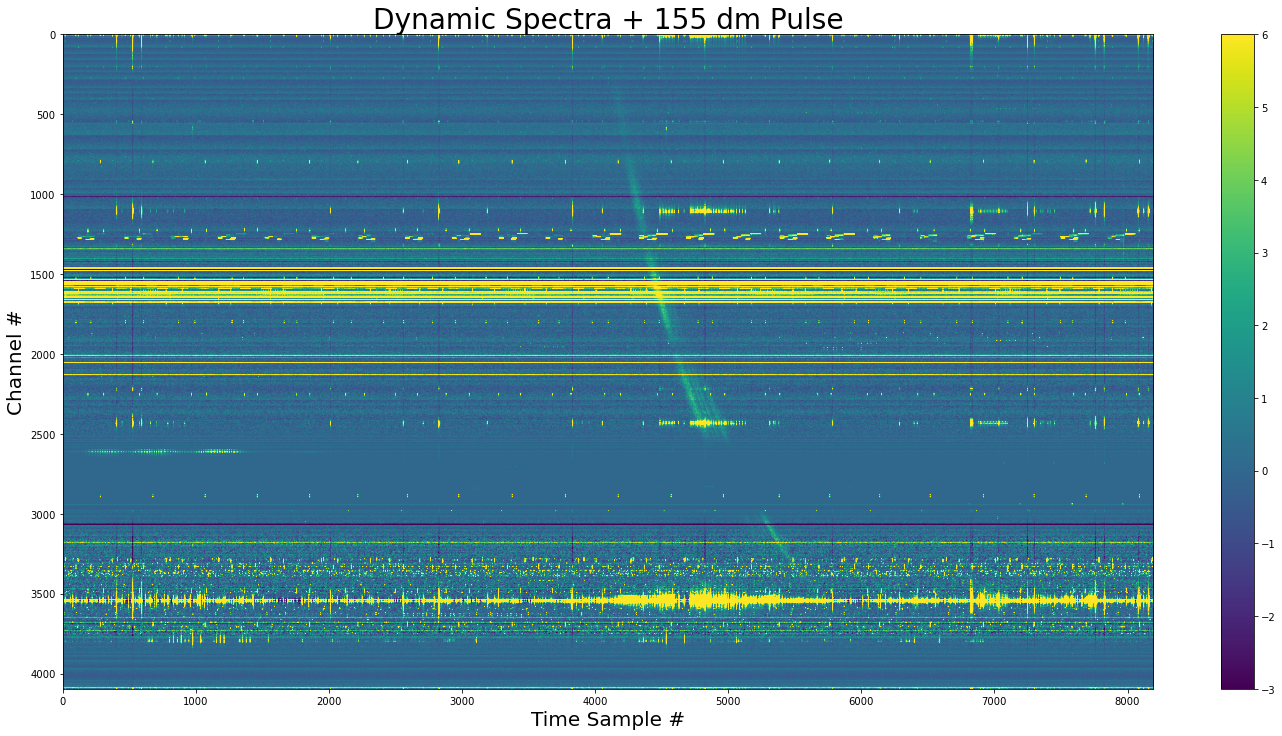

In [14]:
show_dynamic(
    dynamic_spectra_w_complex_pulse, title=f"Dynamic Spectra + {dm_1} dm Pulse"
)

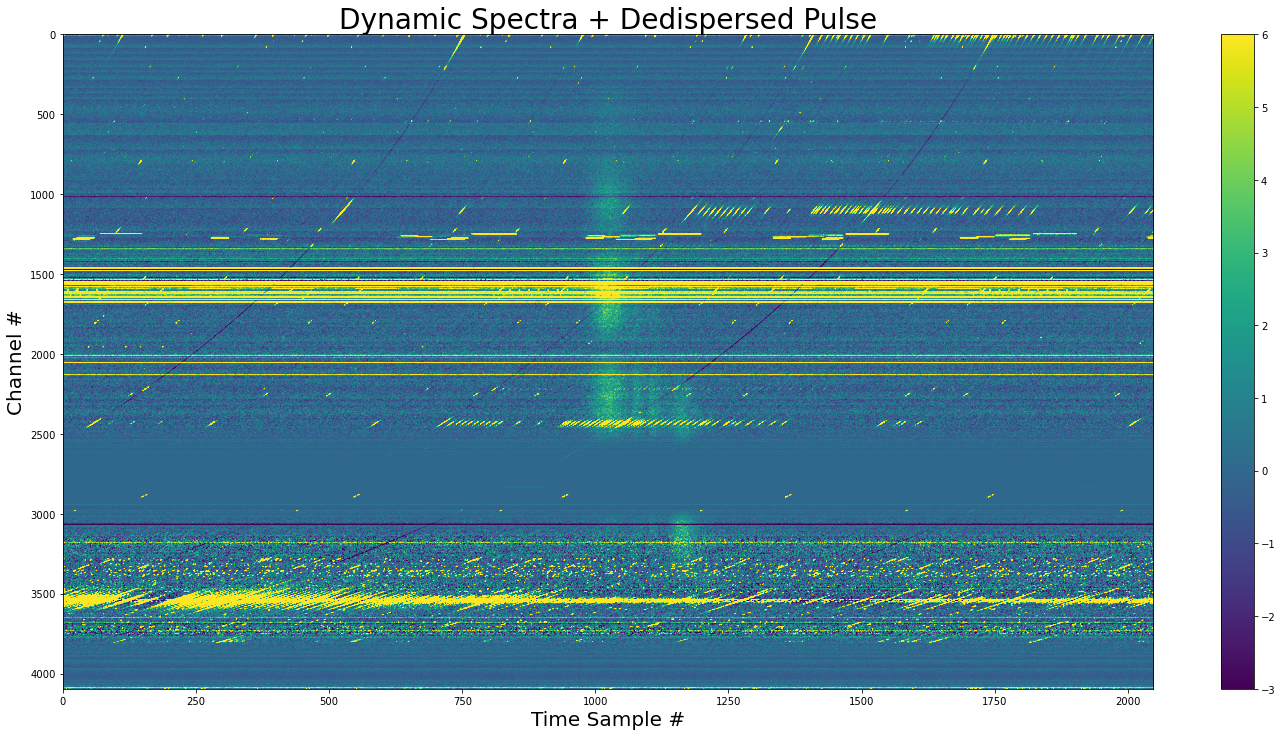

In [15]:
show_dynamic(
    dedisperse(
        dynamic_spectra_w_complex_pulse,
        dm=dm_1,
        chan_freqs=yr_obj.chan_freqs,
        tsamp=yr_obj.your_header.tsamp,
    )[3072:-3072],
    title="Dynamic Spectra + Dedispersed Pulse",
)

The dedispersed pulse showing the downward drift

## Periodic pulses w/ constant Fluence

In [16]:
dynamic_spectra_w_pulse_perodic = inject.inject_constant_into_file(
    yr_input=yr_obj,
    pulse=pulse,
    start=0,
    period=1234,
    gulp=yr_obj.your_header.nspectra,
)

Output()

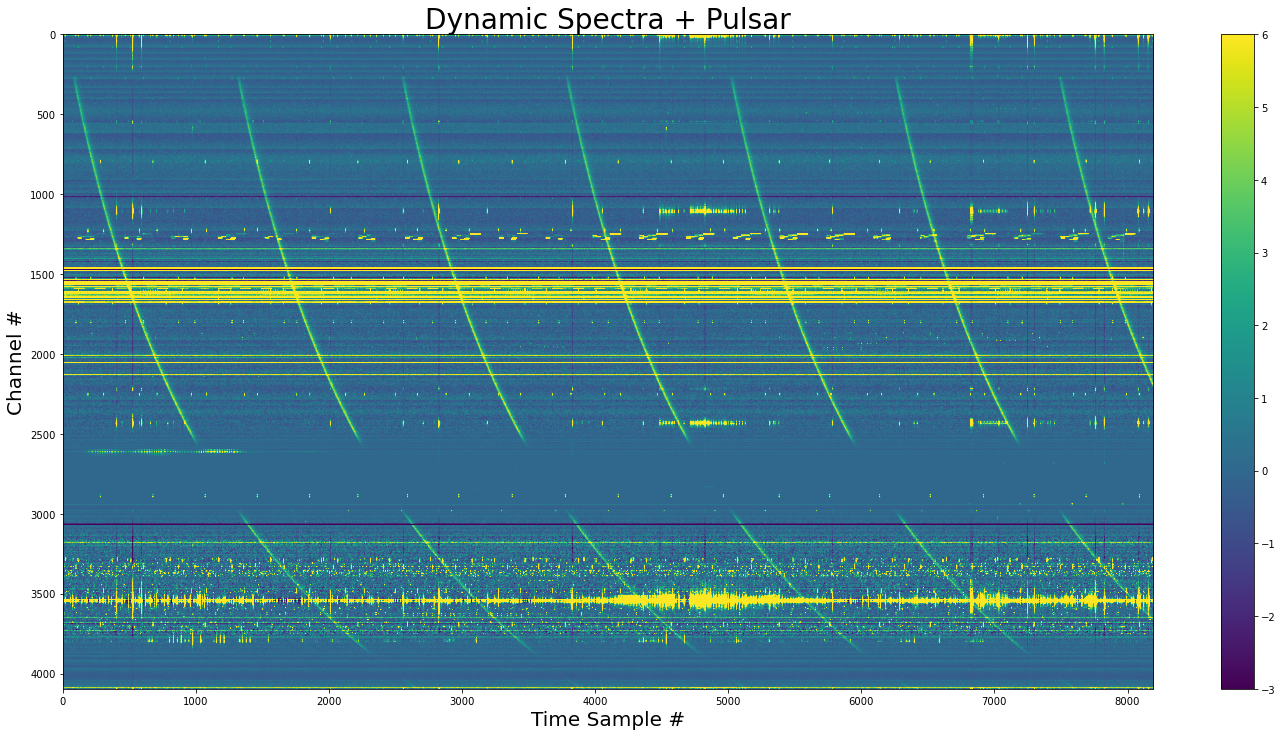

In [17]:
show_dynamic(dynamic_spectra_w_pulse_perodic, title="Dynamic Spectra + Pulsar")

Now we have a pulsar with a period of `1234` samples

## Variable Fluence

In [18]:
# Calculate the number of pulses needed
n_pulses = inject.num_pulses(period=1234, nspectra=yr_obj.your_header.nspectra)
print(f"Number of pulses: {n_pulses}")

Number of pulses: 7


In [19]:
np.random.seed(2021)
pulse_energies = np.random.normal(loc=3e5, scale=2e5, size=n_pulses)
# pulse engergies must be an interger number of samples
np.around(pulse_energies, out=pulse_energies)
# must be positive
pulse_energies = pulse_energies.astype(int)
np.clip(pulse_energies, 0, None, out=pulse_energies)
print(f"{pulse_energies=}")

pulse_energies=array([597722, 435202, 216310, 138696, 411175, 158899, 526172])


In [20]:
dynamic_spectra_w_pulse_perodic_diff_energies = inject.inject_distribution_into_file(
    yr_input=yr_obj,
    pulse_obj=pulse_obj,
    pulse_counts=pulse_energies,
    start=0,
    period=1234,
    gulp=yr_obj.your_header.nspectra,
)

Output()

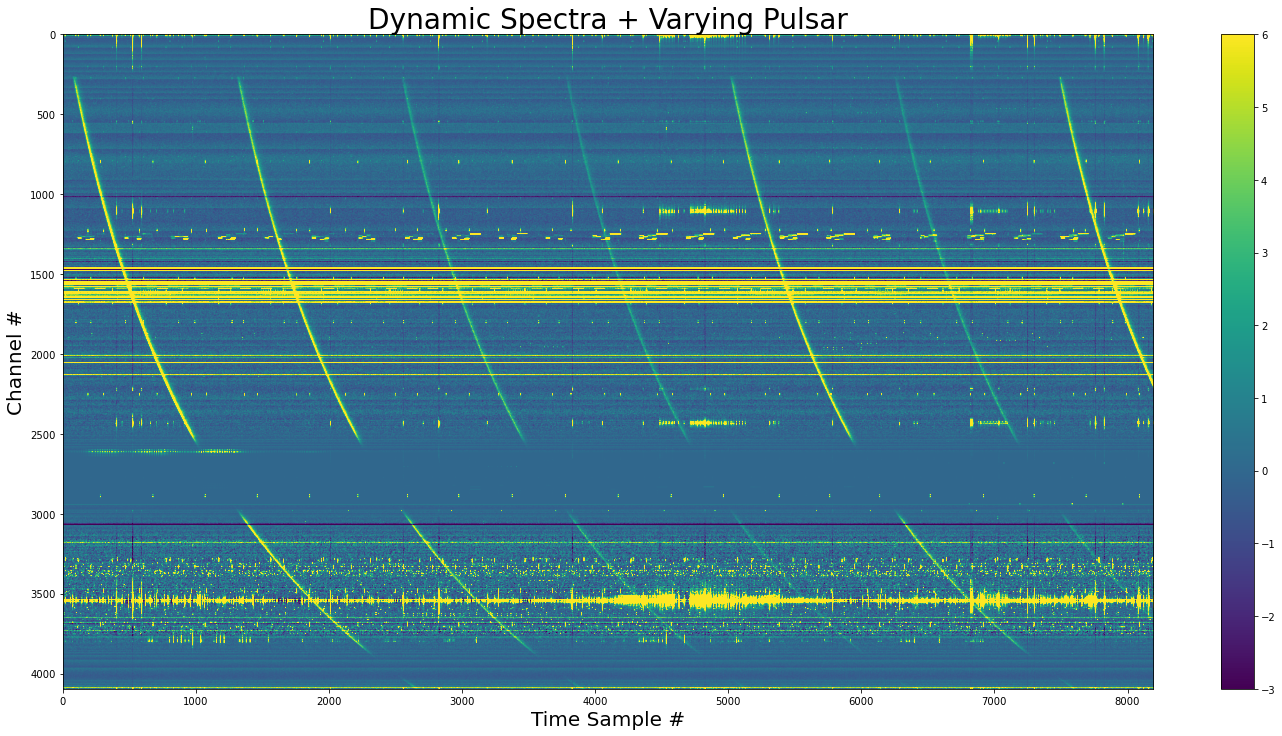

In [21]:
show_dynamic(
    dynamic_spectra_w_pulse_perodic_diff_energies,
    title="Dynamic Spectra + Varying Pulsar",
)

Now we have pulse-to-pulse variation of intensities.